In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
rna = ad.read_loom('/home/mffang/data/counts/Johnson_2022/STORMSEQ/counts_unfiltered/adata.loom',validate=False)
rna

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 70 × 62846
    obs: 'barcode'
    var: 'target_name'
    layers: 'ambiguous', 'mature', 'nascent'

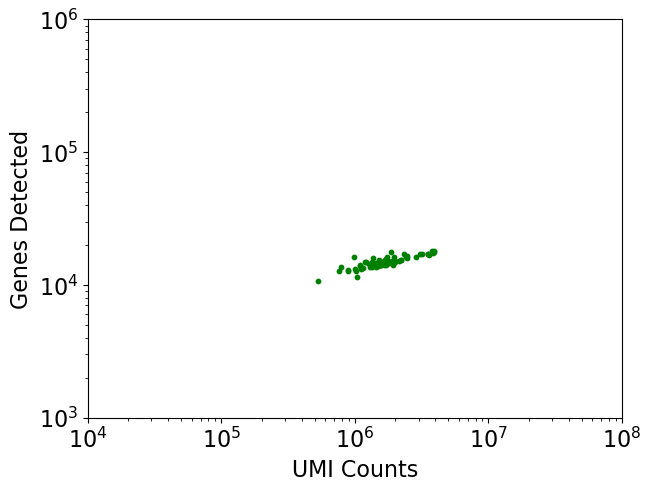

In [4]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots()

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=10, alpha=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e4,1e8))
ax.set_ylim((1e3,1e6))

plt.show()

In [5]:
import statistics

statistics.median(mtx.sum(axis=1))

1623896.0

In [6]:
rna.obs

,barcode
0,AAAAAAAAAAAAAAAA
1,AAAAAAAAAAAAAAAC
2,AAAAAAAAAAAAAAAG
3,AAAAAAAAAAAAAAAT
4,AAAAAAAAAAAAAACA
...,...
65,AAAAAAAAAAAACAAC
66,AAAAAAAAAAAACAAG
67,AAAAAAAAAAAACAAT
68,AAAAAAAAAAAACACA


In [7]:
rna.var

,target_name
0,ENSG00000279928.2
1,ENSG00000228037.1
2,ENSG00000142611.17
3,ENSG00000284616.1
4,ENSG00000157911.11
...,...
62841,ERCC-00164
62842,ERCC-00165
62843,ERCC-00168
62844,ERCC-00170


## Calculate CV$^2$ of read depth

In [8]:
adata = rna.copy()
adata.X = rna.layers['ambiguous']+rna.layers['mature']+rna.layers['nascent']
ERCC = adata[:,-92:]
adata = adata[:,:-92]

4.798779 7.0685077 17.218842


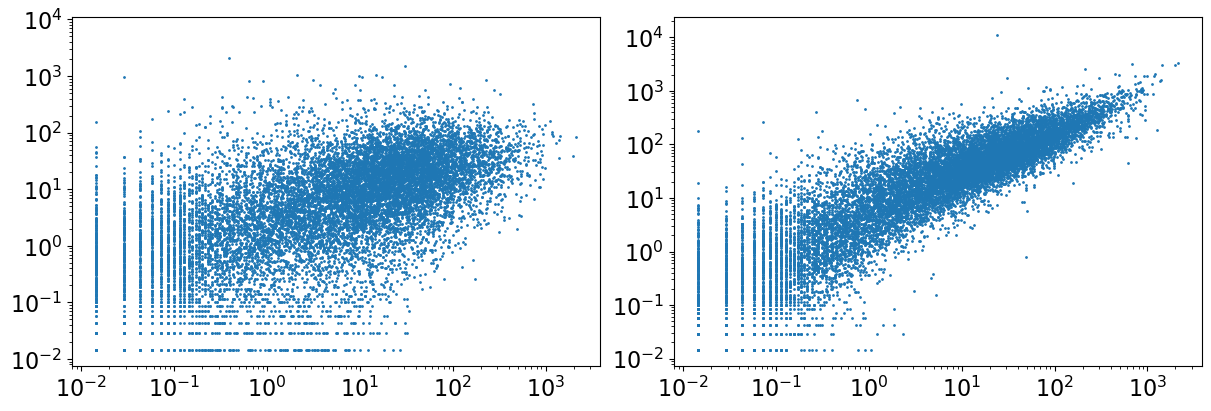

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

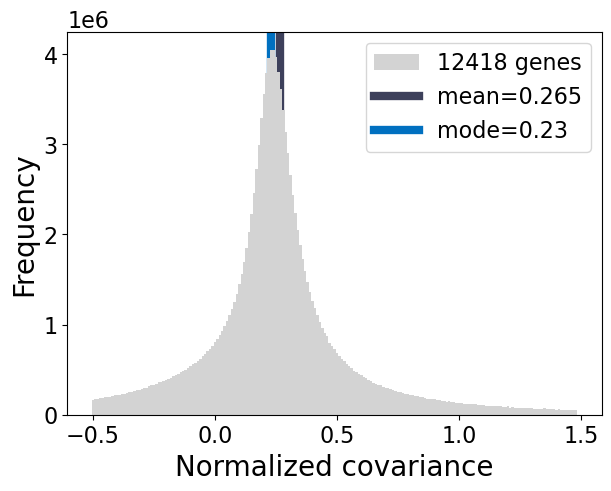

In [11]:
fig,axs = plt.subplots(1,1,figsize=(6,4.8))
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

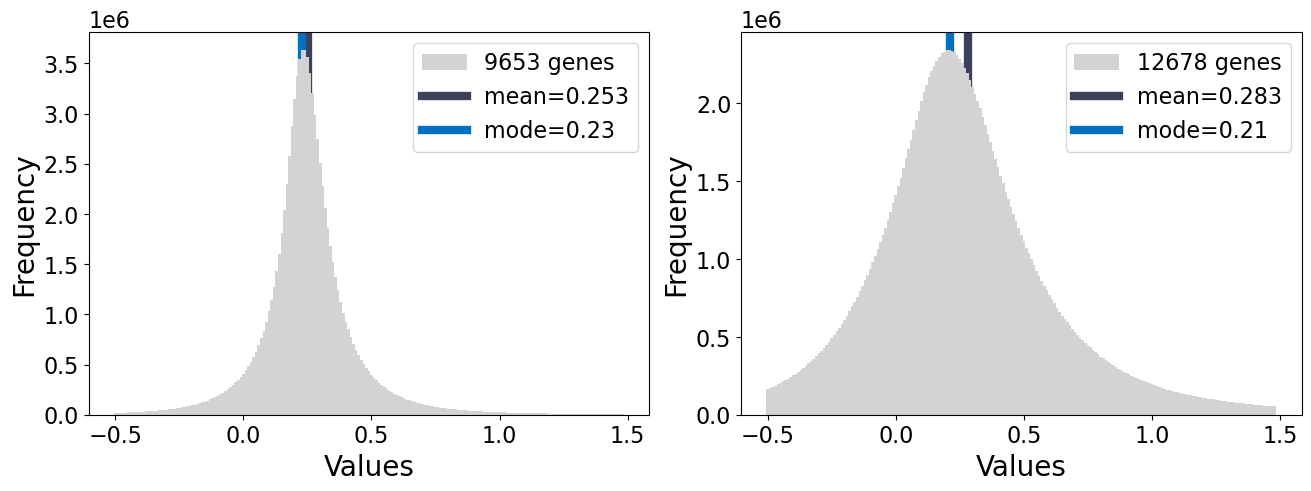

In [18]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=1,var_threshold=np.inf,n_iter=0)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [12]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50)

/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/utils.py:242: RuntimeWarning: invalid value encountered in divide
  eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
/home/mffang/workspace/Extrinsic/FP_2025/util

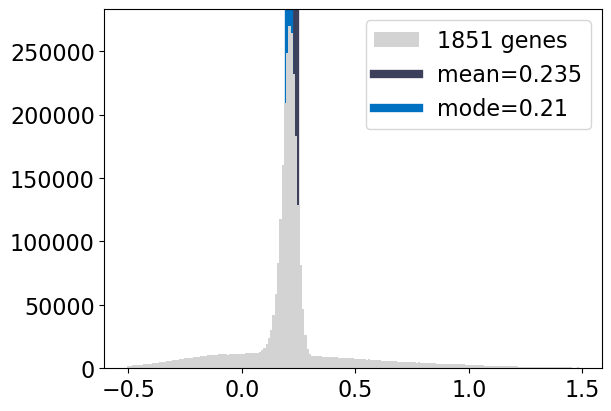

In [13]:
s = 0.23

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1,figsize=(6,4))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs,min_mean=0.1)

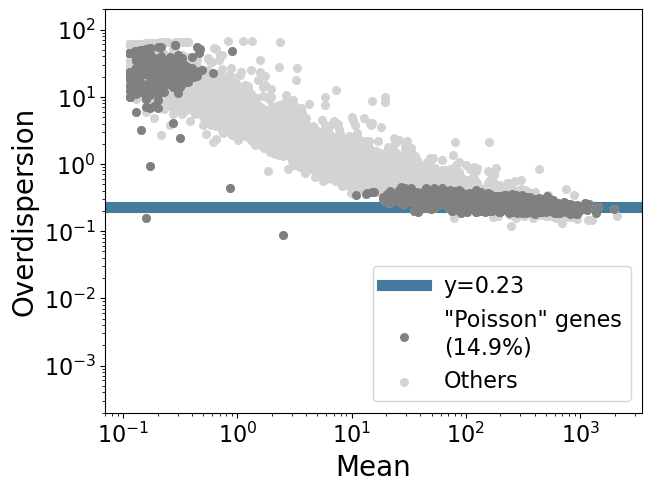

In [14]:
s = 0.23

X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

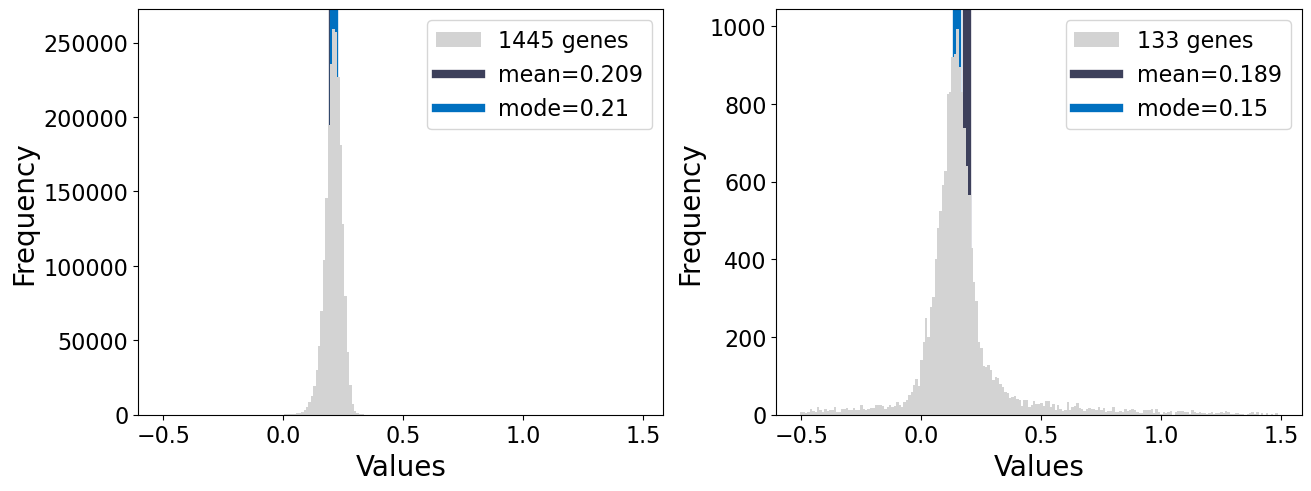

In [34]:
fig,axs = plt.subplots(1,2,figsize=(13,4.8))

X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = S_Pgene_mask.copy()
s = estimate_s(X_[:,Pgene_mask],ax=axs[0],min_mean=1,var_threshold=np.inf,n_iter=0)

X_ = adata.layers["nascent"].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
Pgene_mask = U_Pgene_mask.copy()
s = estimate_s(X_[:,Pgene_mask],ax=axs[1],min_mean=1,var_threshold=np.inf,n_iter=0)

for i in range(2):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

100%|██████████| 100/100 [00:00<00:00, 116.91it/s]


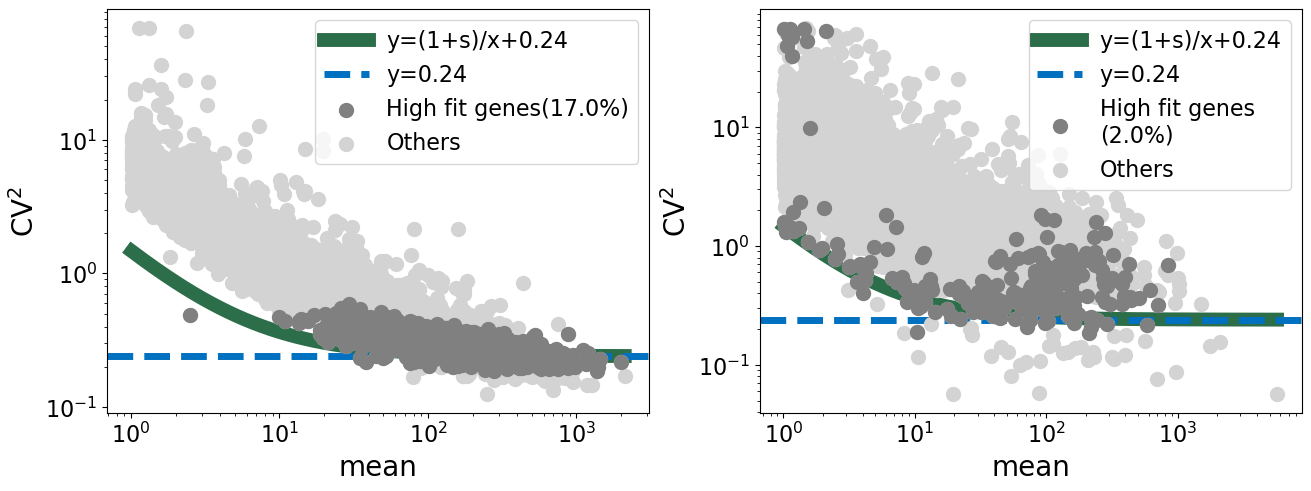

In [24]:
fig,ax = plt.subplots(1,2,figsize=(13,4.8))

s = ss
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
cv2 = s
lower_bound, upper_bound = bootstrapping_cv2(X_,alpha=0.05,B=100,seed=0)
Pgene_mask = (cv2 < upper_bound) & (cv2 > lower_bound) 
S_Pgene_mask = Pgene_mask.copy()

ax[0].plot(np.sort(X_mean), (1+s)/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=(1+s)/x+'+str(np.around(s,3)))
ax[0].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='High fit genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('mean',fontsize=20)
ax[0].set_ylabel(r'CV$^2$',fontsize=20)
ax[0].legend(loc='upper right',fontsize=16);

s = su
X_ = adata.layers["nascent"].toarray().copy()
nonzero_idx = X_.mean(0)>1
X_ = X_[:,nonzero_idx]
cv2 = s
X_var = X_.var(0)
X_mean = X_.mean(0)
lower_bound, upper_bound = bootstrapping_cv2(X_,alpha=0.05,B=100,seed=0)
Pgene_mask = (cv2 < upper_bound) & (cv2 > lower_bound) 
U_Pgene_mask = Pgene_mask.copy()

ax[1].plot(np.sort(X_mean), (1+s)/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=(1+s)/x+'+str(np.around(s,3)))
ax[1].axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,3)))
ax[1].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='High fit genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[1].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('mean',fontsize=20)
ax[1].set_ylabel(r'CV$^2$',fontsize=20)
ax[1].legend(loc='upper right',fontsize=16);

# Check covariance relationships

In [35]:
min_mean = 1
s = 0.2

idx = (adata.layers["nascent"].toarray().mean(0) > min_mean) & (adata.layers["mature"].toarray().mean(0) > min_mean)

U = adata.layers["nascent"][:,idx].toarray()
S = adata.layers["mature"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = ((U_var-U_mean)/U_mean**2-s)/(1+s)
zeta_ss = ((S_var-S_mean)/S_mean**2-s)/(1+s)

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = ((cov_us)/S_mean/U_mean-s)/(1+s)
zeta_us.shape

(8603,)

## Var(N_U)

Text(0.5, 1.0, '99.91% of cells >= 0')

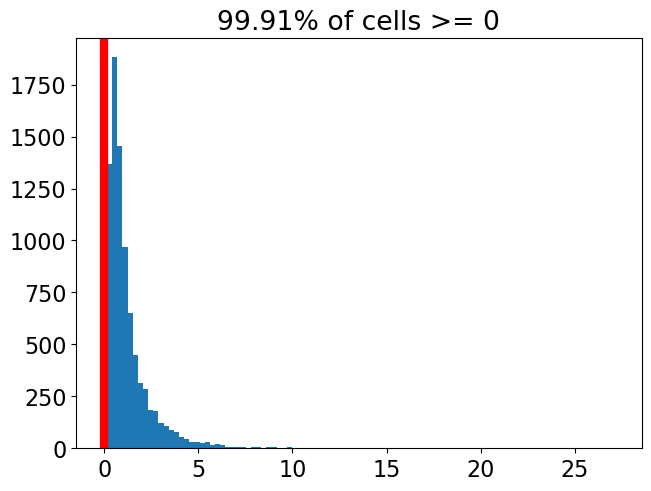

In [36]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

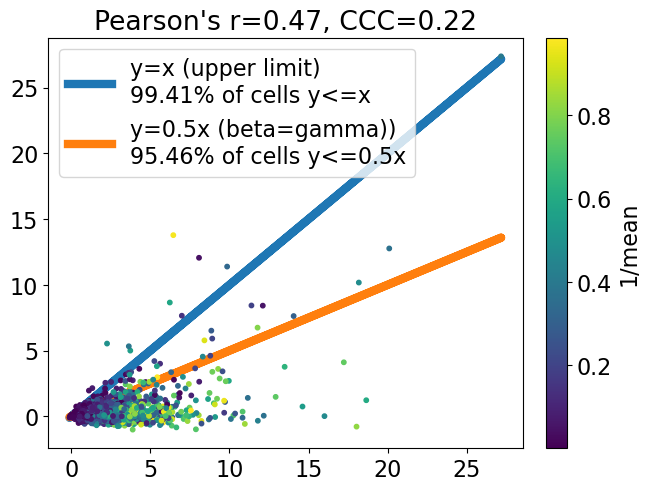

In [37]:
x=zeta_uu
y=zeta_us

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

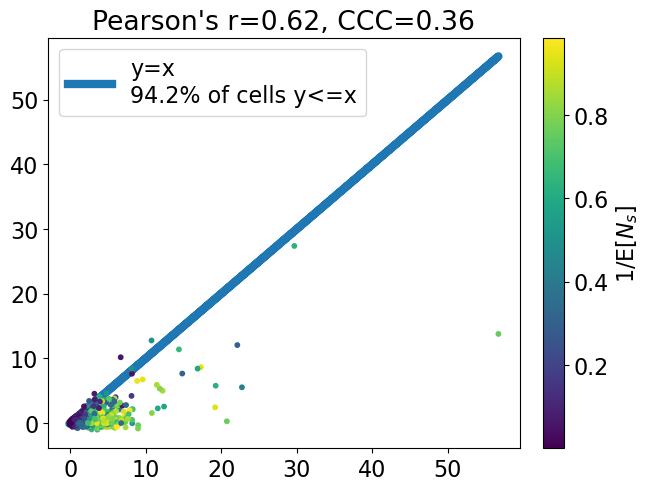

In [38]:
x=zeta_ss
y=zeta_us

plt.plot(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()